    # Output CN plot

In [1]:
import matplotlib
import matplotlib.pyplot as plt
# imports
import scgenome.plotting as pl
import h5py
import anndata
import numpy as np

/Users/haraldme/miniconda3/envs/victree/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/haraldme/miniconda3/envs/victree/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/haraldme/miniconda3/envs/victree/lib/python3.10/site-

In [2]:
import os
print(os.getcwd())


/Users/haraldme/git/Lagergren Lab/CopyTree/VICTree/victree/src/experiments


In [3]:
import json
base_path = "../../output/P01-066"
data_set = "K12L5i200step0p1splitMixed2"
experiment_seed = ""
path = os.path.join(base_path, data_set)
path = os.path.join(path, experiment_seed)

out_file = anndata.read_h5ad(os.path.join(path, 'victree.out.h5ad')) # 014
model_file = h5py.File(os.path.join(path, 'victree.model.h5')) # 014
with open(os.path.join(path, "victree.config.json")) as file:
    config_file = json.load(file)

print(f'out file keys: {out_file}')
print(f'model file keys: {model_file.keys()}')
print(f'config keys: {config_file}')

out file keys: AnnData object with n_obs × n_vars = 683 × 6206
    obs: 'victree-mu', 'victree-mt-lambda', 'victree-mt-alpha', 'victree-mt-beta', 'victree-tau', 'victree-clone', 'victree-loglik'
    var: 'bin', 'chr', 'start', 'end'
    uns: 'victree-eps-alpha', 'victree-eps-beta', 'victree-tree-graph', 'victree-tree-newick', 'victree-tree-probs'
    obsm: 'victree-clone-probs'
    varm: 'victree-cn-pprobs', 'victree-cn-sprobs'
    layers: 'victree-cn-marginal', 'victree-cn-viterbi'
model file keys: <KeysViewHDF5 ['VarTreeJointDist', 'qCMultiChrom', 'qEpsilonMulti', 'qMuTau', 'qPi', 'qT', 'qZ']>
config keys: {'step_size_delay': 2.0, 'step_size_forgetting_rate': 0.7, 'step_size_scheme': 'None', 'batch_size': 20, 'SVI': False, 'split': 'mixed', 'curr_it': 200, 'qc_smoothing': False, '_diagnostics': True, 'step_size': 0.1, 'annealing': 1.0, '_n_nodes': 12, '_n_states': 7, '_eps0': 0.01, '_n_cells': 683, '_chain_length': 6206, '_n_chromosomes': 24, '_chromosome_indexes': [499, 986, 1383, 1

/Users/haraldme/miniconda3/envs/victree/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
print(out_file.layers.keys())
print(out_file.obs.keys())

KeysView(Layers with keys: victree-cn-marginal, victree-cn-viterbi)
Index(['victree-mu', 'victree-mt-lambda', 'victree-mt-alpha',
       'victree-mt-beta', 'victree-tau', 'victree-clone', 'victree-loglik'],
      dtype='object')


In [5]:
# get cell assignment and cell copy number
top_z = out_file.obsm['victree-clone-probs'][...].argmax(axis=1)
clone_cn_np = out_file.layers['victree-cn-marginal'][...].argmax(axis=-1)
cell_cn = clone_cn_np[top_z, :]

In [6]:
from utils import factory_utils

qC = factory_utils.construct_qCMultiChrome_from_model_output_data(model_file)
qC.compute_filtering_probs()
print(qC.single_filtering_probs[1, 0:3])

/Users/haraldme/git/Lagergren Lab/CopyTree/VICTree/victree/src/utils/factory_utils.py:91: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1675740407425/work/torch/csrc/utils/tensor_new.cpp:233.)
  eta1 = torch.tensor(qC_params[key]['eta1'])


tensor([[9.1449e-05, 9.1449e-05, 9.9945e-01, 9.1449e-05, 9.1449e-05, 9.1449e-05,
         9.1449e-05],
        [1.0263e-04, 1.0263e-04, 9.9938e-01, 1.0263e-04, 1.0263e-04, 1.0264e-04,
         1.0264e-04],
        [1.0000e-08, 1.0000e-08, 1.0000e+00, 1.0000e-08, 1.0000e-08, 1.0000e-08,
         1.0000e-08]])


In [7]:
# create anndata
# adata = anndata.read_h5ad('/Users/zemp/Downloads/data/signals_SPECTRUM-OV-006.h5')
adata = anndata.read_h5ad('../../data/x_data/P01-066_cn_data.h5ad')
# adata = anndata.read_h5ad('/Users/zemp/Downloads/data/signals_SPECTRUM-OV-107.h5')


adata.obs['clone'] = top_z

In [8]:
print(cell_cn.shape)
print(clone_cn_np.shape)

(683, 6206)
(683, 6206)


In [9]:
from utils import visualization_utils
matplotlib.use('Qt5Agg')
qC_marginals_np = qC.single_filtering_probs.numpy()
qC_argmax = qC_marginals_np.argmax(axis=-1)
#visualization_utils.visualize_copy_number_profiles_ipynb()
import matplotlib.pyplot as plt

print(qC_argmax[5, 5000:5200])

[1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


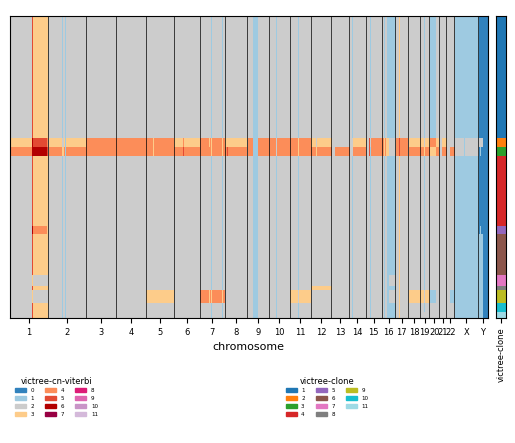

In [48]:
%matplotlib inline
#out_file.layers['victree-cn-marginal'] = cell_qc.get_viterbi()[1:].numpy()
g = pl.plot_cell_cn_matrix_fig(out_file, 'victree-cn-viterbi', cell_order_fields=['victree-clone'], annotation_fields=['victree-clone'], max_cn=7)

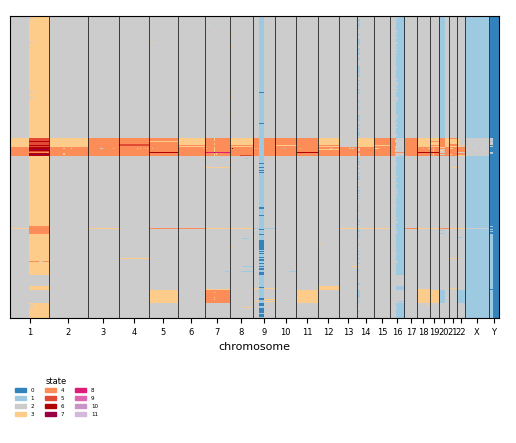

In [41]:
adata.obs['victree-clone'] = out_file.obs['victree-clone']
g = pl.plot_cell_cn_matrix_fig(adata, 'state', cell_order_fields=['clone'])

<Axes: xlabel='chromosome'>

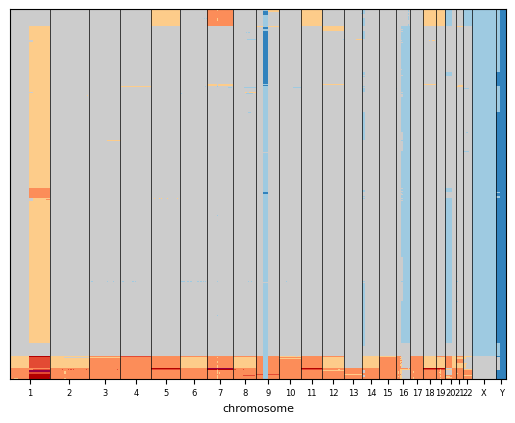

In [12]:
pl.plot_cell_cn_matrix(adata, 'state', cell_order_fields=['clustering_order'], max_cn=7)['ax']

/var/folders/gt/k64xtzx97m9dchpngd2j_xp40000gp/T/ipykernel_21746/4006104823.py:6: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(mst, prog="dot")


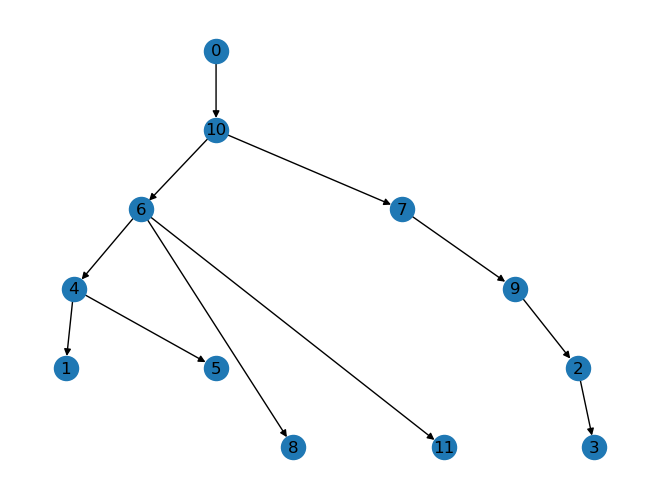

In [32]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
adj_matrix = out_file.uns['victree-tree-graph']
G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)
mst = nx.maximum_spanning_arborescence(G)
pos = graphviz_layout(mst, prog="dot")
nx.draw(mst, pos=pos, with_labels=True)

In [47]:
qZ_probs = out_file.obsm['victree-clone-probs'][...]
clonal_fractions = np.mean(qZ_probs, axis=0)
print(clonal_fractions)

[0.    0.403 0.032 0.029 0.231 0.025 0.136 0.037 0.013 0.045 0.027 0.022]


In [34]:
import numpy as np
np.unique(top_z, return_counts=True)

array([ 1,  1,  4,  6,  8,  5,  1,  6, 10,  4,  6,  6,  6,  9, 11,  3,  1,
        1,  9,  6,  4,  6,  6,  1,  4,  1,  1, 10,  1,  1,  9, 10,  1,  7,
        1,  4,  4,  1,  6,  4,  1,  6,  1,  1,  1,  3,  1,  1,  4,  8,  1,
        6, 11,  3,  7,  9,  1,  1,  6,  6,  8,  6, 11,  1,  4,  4,  2,  1,
        1, 10,  1,  6,  4,  4,  4,  1,  1,  6,  4,  6,  4,  4,  4, 10,  6,
        1,  4,  3,  1,  4,  5,  6,  9, 10,  1,  1,  1,  1,  4, 10,  6,  7,
        6,  7,  4,  1,  8,  1,  4,  7,  1,  4,  1,  1,  1,  1,  4,  4,  1,
        1,  9,  1,  1,  1, 10,  4,  1,  1,  1,  3,  1,  1,  8,  1,  1,  7,
        9,  1,  4,  4,  2,  2,  4,  1,  1,  4,  4,  1,  1,  1,  9,  6,  6,
        1,  5,  1,  1,  3,  4, 10, 10,  1,  1,  1,  1,  4,  3,  2,  4,  4,
        1,  2,  1,  6,  1,  1,  1,  6,  1,  6,  1,  6,  4,  1,  1,  1,  6,
        1,  4,  1,  1,  1,  5,  8,  1, 11,  4,  4,  1,  1,  1,  6,  9,  5,
        1,  6,  1,  4,  1,  1,  1,  4,  4,  4,  1,  4,  6,  9,  1,  7,  4,
        1,  4,  2,  3,  1

In [32]:
out_file['result']['trees'].keys()

<KeysViewHDF5 ['newick', 'weight']>

In [33]:

for t in zip(out_file['result']['trees']['newick'], out_file['result']['trees']['weight']):
    print(t[0])
    print(t[1])
    print('---')

b'((2,(1,5)4)3)0'
0.02043939
---
b'((((5)2)1,3)4)0'
0.013640878
---
b'(((5)1,(3)2)4)0'
0.013598051
---
b'(1,(2,(5)3)4)0'
0.013593179
---
b'((2,(3)4)1,5)0'
0.013571922
---
b'((3,5)2,(1)4)0'
0.013564752
---
b'(2,(1,4)3,5)0'
0.01355846
---
b'((1,4)2,3,5)0'
0.013556236
---
b'((2,((5)3)4)1)0'
0.013550264
---
b'((1)2,(4,5)3)0'
0.013547564
---
b'((1,(3)2,5)4)0'
0.013543362
---
b'(((4,5)2,3)1)0'
0.013538791
---
b'(((2,3)4,5)1)0'
0.0135366
---
b'((1,(2,5)4)3)0'
0.0135211
---
b'((4)1,(2,5)3)0'
0.013488823
---
b'(((3)1,5)2,4)0'
0.013478719
---
b'(1,(((5)2)4)3)0'
0.013476964
---
b'((2,(3,5)4)1)0'
0.013476209
---
b'(2,((1,5)4)3)0'
0.0134605905
---
b'(((2,(5)4)1)3)0'
0.01343996
---
b'((3,5)1,(4)2)0'
0.0134385275
---
b'(((5)2,3)1,4)0'
0.013409871
---
b'(((3)1)2,(5)4)0'
0.013383034
---
b'((2)1,(5)3,4)0'
0.013311512
---
b'(((3,(1)4)2)5)0'
0.012144192
---
b'(((1,(4)2)3)5)0'
0.012141792
---
b'(((1,2,4)3)5)0'
0.012141299
---
b'((((4)1,2)3)5)0'
0.01205685
---
b'((((1)5)2,3)4)0'
0.012046414
---
b'(((((1)5)3